<a href="https://colab.research.google.com/github/EmanSmadi/Mask_detection/blob/master/Mask_medvidipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%ls /gdrive

Mounted at /gdrive
'My Drive'/


In [ ]:
!pip install keras==2.1.0

     |████████████████████████████████| 307kB 8.5MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!ls '/gdrive/My Drive/Colab Notebooks'

'all med100.ipynb'
 apex
'Copy of all med200.ipynb'
'Copy of LSTM with Hyperas - Auto Tuning for stock return prediction - MAv2.ipynb'
'Copy of Q3 - Inv. Assignment NLP'
'Copy of Tutorial_SingleM_Template'
'Copy of yoloColabDemo.ipynb'
 Eman_xlm-mlm-en-2048_B.ipynb
' Eman_xlm-mlm-ende-1024_A.ipynb'
'Ensemble - 5 models - with highest prob & words count - Eman.ipynb'
 ind_assign_Q3
 Kaggle.ipynb
'LSTM with Hyperas - Auto Tuning for stock price prediction - Visa.ipynb'
'LSTM with Hyperas - Auto Tuning for stock return prediction - AAPL.ipynb'
'LSTM with Hyperas - Auto Tuning for stock return prediction - AT&Tv2.ipynb'
'LSTM with Hyperas - Auto Tuning for stock return prediction - BACv2.ipynb'
'LSTM with Hyperas - Auto Tuning for stock return prediction - DIS.ipynb'
'LSTM with Hyperas - Auto Tuning for stock return prediction - DISv2.ipynb'
'LSTM with Hyperas - Auto Tuning for stock return prediction - INTCv2.ipynb'
'LSTM with Hyperas - Auto Tuning for stock return prediction - MA.ipynb'


In [ ]:
from glob import glob, iglob
import os
from random import random
import json

In [ ]:
print(os.getcwd())

/content


In [ ]:
%cd /gdrive/My Drive/Colab Notebooks/Mask_RCNN

/gdrive/My Drive/Colab Notebooks/Mask_RCNN


In [ ]:
!pwd

/gdrive/My Drive/Colab Notebooks/Mask_RCNN


In [ ]:
import sys
import itertools
import math
import logging
import random
import re
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

In [ ]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

Using TensorFlow backend.


In [ ]:
#own dataset
from samples.Mask import Mask

In [ ]:
%matplotlib inline

config = Mask.medConfig()

In [ ]:
#change directory to your own
med_DIR = "/gdrive/My Drive/Colab Notebooks/meddata_mask"

In [ ]:
# Load dataset
# Get the dataset from the releases page
dataset = Mask.medDataset()
dataset.load_med(med_DIR, "train")

In [ ]:
# Must call before using the dataset
dataset.prepare()

In [ ]:
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 395
Class Count: 3
  0. BG                                                
  1. Mask                                              
  2. NO_Mask                                           


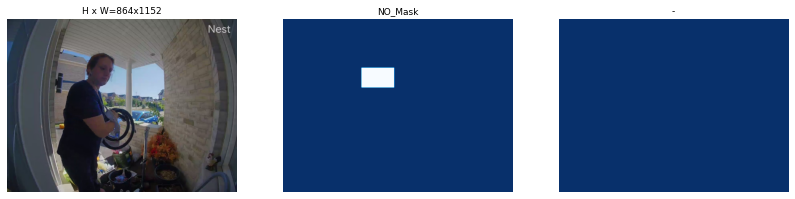

[2]


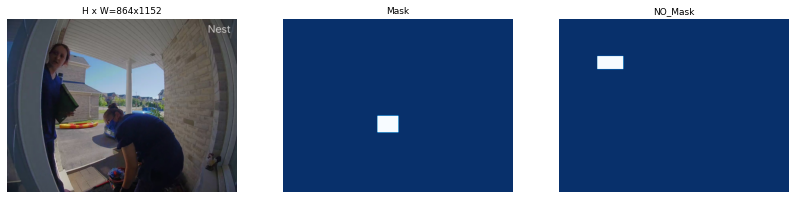

[2, 1]


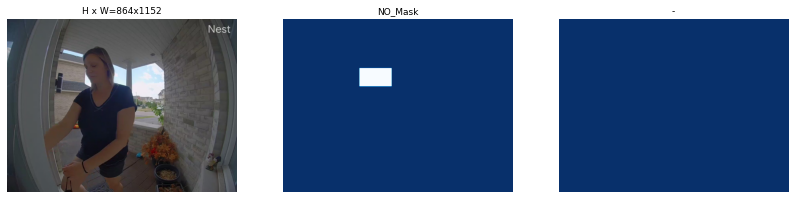

[2]


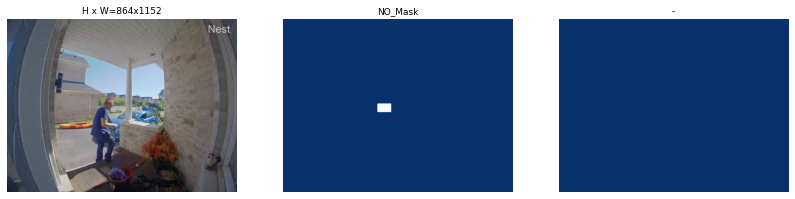

[2]


In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids,4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    class_ids = [int(x) for x in class_ids]
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=2)
    print(class_ids)

image_id  139 /gdrive/My Drive/Colab Notebooks/meddata_mask/train/frame10225.jpg
image                    shape: (864, 1152, 3)        min:    0.00000  max:  255.00000  uint8
mask                     shape: (864, 1152, 1)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    2.00000  max:    2.00000  int64
bbox                     shape: (1, 4)                min:  238.00000  max:  621.00000  int32


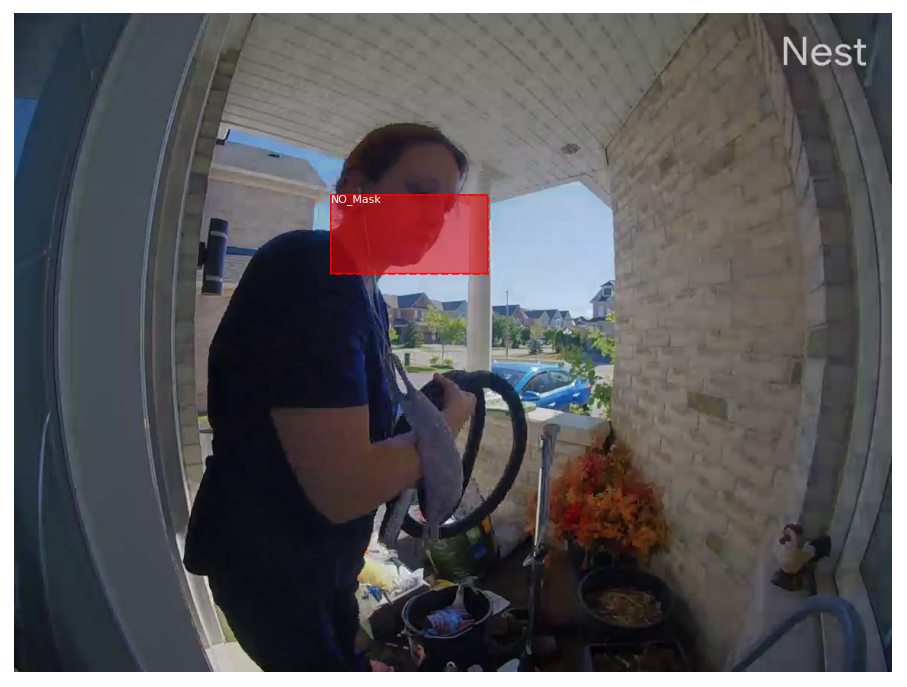

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
class_ids = np.array([int(x) for x in class_ids])
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)


In [ ]:
## Create Model 
#dataset

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

## Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 100
    #FPN_CLASSIF_FC_LAYERS_SIZE = 1028
    #IMAGE_MAX_DIM = 1028
    #IMAGE_SHAPE = [1028, 1028, 3]

config = InferenceConfig()
config.display()

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    #Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
# Training dataset
dataset_train = Mask.medDataset()
dataset_train.load_med(med_DIR, "train")
dataset_train.prepare()

In [ ]:
# validation dataset
dataset_val = Mask.medDataset()
dataset_val.load_med(med_DIR, "val")
dataset_val.prepare()

Model Traning! Only run when needed

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
learning_rate=config.LEARNING_RATE, 
epochs=200, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /gdrive/My Drive/Colab Notebooks/Mask_RCNN/logs/mask20200910T2223/mask_rcnn_mask_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/200
 99/100 [============================>.] - ETA: 0s - loss: 1.9002 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.5631 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.6835 - mrcnn_mask_loss: 0.5148

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



100/100 [==============================] - 107s 1s/step - loss: 1.9001 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.5606 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.6854 - mrcnn_mask_loss: 0.5150 - val_loss: 1.3733 - val_rpn_class_loss: 0.0171 - val_rpn_bbox_loss: 0.4123 - val_mrcnn_class_loss: 0.0862 - val_mrcnn_bbox_loss: 0.4633 - val_mrcnn_mask_loss: 0.3944
Epoch 2/200
100/100 [==============================] - 31s 313ms/step - loss: 1.1675 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.2859 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.4083 - mrcnn_mask_loss: 0.3937 - val_loss: 1.2150 - val_rpn_class_loss: 0.0117 - val_rpn_bbox_loss: 0.3208 - val_mrcnn_class_loss: 0.0605 - val_mrcnn_bbox_loss: 0.4110 - val_mrcnn_mask_loss: 0.4111
Epoch 3/200
100/100 [==============================] - 32s 316ms/step - loss: 1.0435 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2501 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.3867 - mrcnn_mask_loss: 0.3436 - val_loss: 0.9594 - val_rpn_class_loss:

In [ ]:
#Detection

from mrcnn.config import Config

class medConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "Mask"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # Background + Mask + No_mask

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

class InferenceConfig(medConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)


# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()


# Load trained weights
print("Loading weights from ", model_path)

model.load_weights(model_path, by_name=True)

Loading weights from  /gdrive/My Drive/Colab Notebooks/Mask_RCNN/logs/mask20200910T2223/mask_rcnn_mask_0200.h5
Re-starting from epoch 200


In [ ]:
model_path

'/gdrive/My Drive/Colab Notebooks/Mask_RCNN/logs/mask20200910T2223/mask_rcnn_mask_0200.h5'

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 1152.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  264.00000  max:  501.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


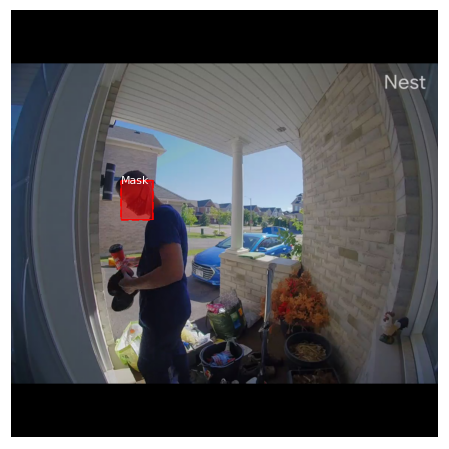

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


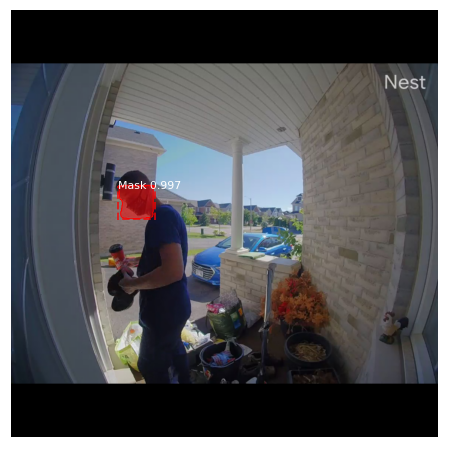

In [ ]:
#Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())


In [ ]:
#EVALUATION

#Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
#image_ids = np.random.choice(dataset_val.image_ids, 20)
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.9495412844036697


In [ ]:
from PIL import Image
from IPython import display

--2020-09-11 00:35:38--  https://vetmed.illinois.edu/wp-content/uploads/2020/03/news-covid19-facemasks.jpg
Resolving vetmed.illinois.edu (vetmed.illinois.edu)... 128.174.94.247
Connecting to vetmed.illinois.edu (vetmed.illinois.edu)|128.174.94.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231229 (226K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>] 225.81K   573KB/s    in 0.4s    

2020-09-11 00:35:39 (573 KB/s) - ‘test.jpg’ saved [231229/231229]



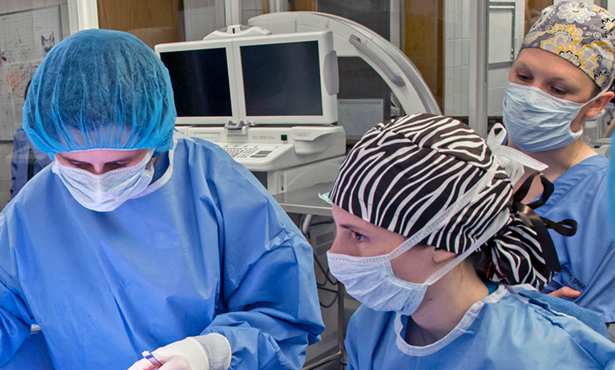

In [ ]:
#test on new images 

!wget https://vetmed.illinois.edu/wp-content/uploads/2020/03/news-covid19-facemasks.jpg -O test.jpg
image_path = 'test.jpg'

with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])
  
image = Image.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path, width=1024))


Processing 1 images
image                    shape: (370, 615, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



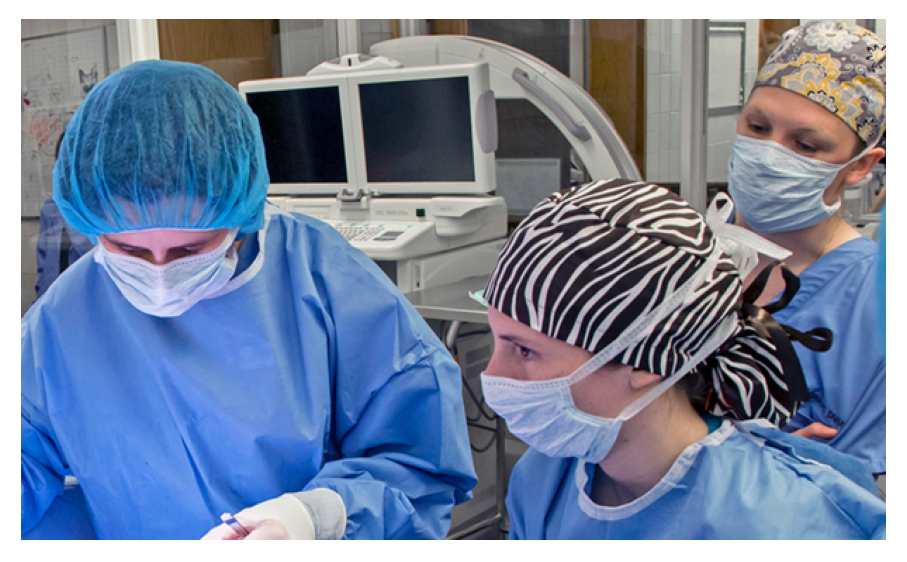

In [ ]:
#Test on a random image

class_names = ['BG', 'Mask','NO_Mask']  
results = model.detect([np_image], verbose=1)

r = results[0]
visualize.display_instances(np_image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])



--2020-09-11 00:36:20--  https://images.glaciermedia.ca/polopoly_fs/1.24106124.1585175907!/fileImage/httpImage/image.jpg_gen/derivatives/landscape_804/dr-ali-okhowat-of-coquitlam-prepares-a-pharyngeal-swab-kit-at-a-covid-19-clini.jpg
Resolving images.glaciermedia.ca (images.glaciermedia.ca)... 45.60.64.112
Connecting to images.glaciermedia.ca (images.glaciermedia.ca)|45.60.64.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134607 (131K) [image/jpeg]
Saving to: ‘test2.jpg’

test2.jpg           100%[===================>] 131.45K  --.-KB/s    in 0.01s   

2020-09-11 00:36:20 (9.01 MB/s) - ‘test2.jpg’ saved [134607/134607]



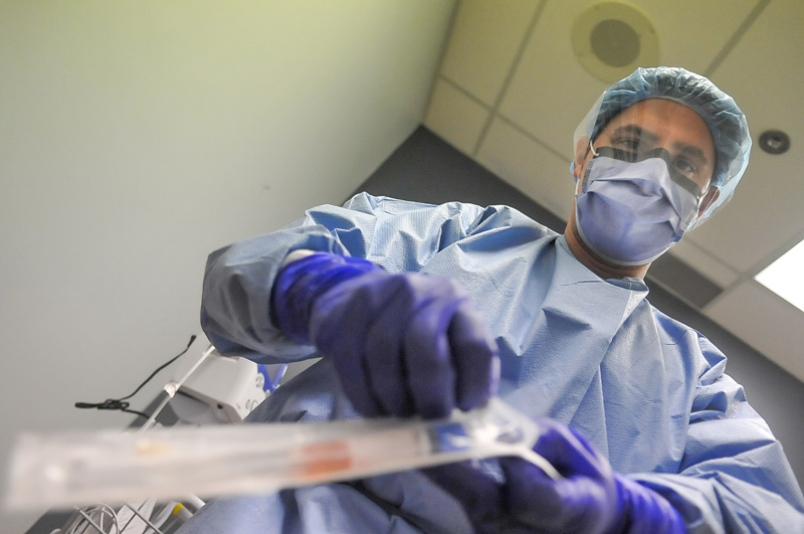

In [ ]:
!wget https://images.glaciermedia.ca/polopoly_fs/1.24106124.1585175907!/fileImage/httpImage/image.jpg_gen/derivatives/landscape_804/dr-ali-okhowat-of-coquitlam-prepares-a-pharyngeal-swab-kit-at-a-covid-19-clini.jpg -O test2.jpg
image_path2 = 'test2.jpg'

with open(image_path2, 'rb') as f:
  np_image_string2 = np.array([f.read()])
  
image2 = Image.open(image_path2)
width, height = image2.size
np_image2 = np.array(image2.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path2, width=1024))

Processing 1 images
image                    shape: (534, 804, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



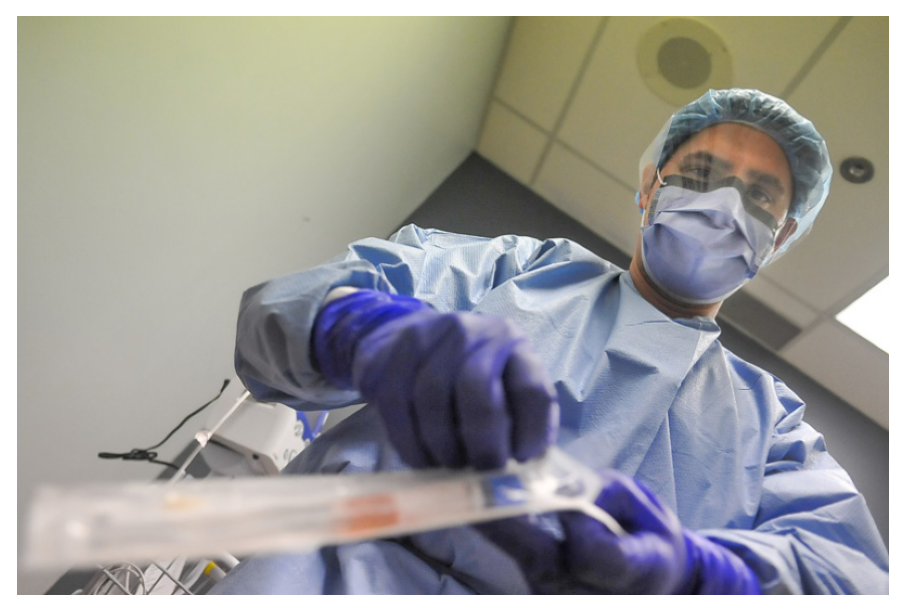

In [ ]:
#Test on a random image

results = model.detect([np_image2], verbose=1)

r = results[0]
visualize.display_instances(np_image2, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

Processing 1 images
image                    shape: (417, 626, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



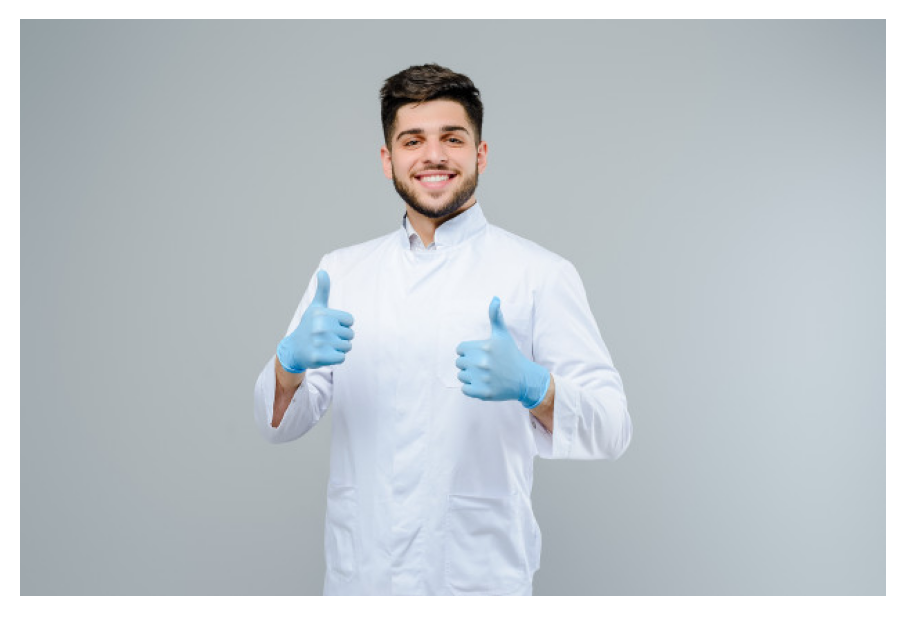

In [ ]:
#Test on a random image

results = model.detect([np_image3], verbose=1)

r = results[0]
visualize.display_instances(np_image3, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

Video section

In [ ]:
import cv2

VIDEO_DIR = os.path.join(ROOT_DIR, "videos")

In [ ]:
def display_instances(image, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]
    colors = visualize.random_colors(n_instances)
    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]
    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue
        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]
        image = visualize.apply_mask(image, mask, color)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image = cv2.putText(
            image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )
    return image

In [ ]:
class_names = ['BG', 'Mask','NO_Mask']  

In [ ]:
def video_to_frames(input_vid, output_loc, max_fps = None):
  # check if folder already exist otherwise mkdir
  if not os.path.exists(output_loc):
    os.mkdir(output_loc)
    print("%s was created" % output_loc)
  # log the time
  time_start = time.time()
  # capture frame
  cap = cv2.VideoCapture(input_vid)
  count = 0
  print('\nRunning Mask R-CNN on %s' % input_vid)
  
  try:
    while True:
      status, image = cap.read()
      # run detection
      results = model.detect([image], verbose = 0)
      # visualization
      r = results[0]
      result_image = display_instances(
          image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores']
      )
      cv2.imwrite(output_loc + "/frame%04d.jpg" % count, result_image)
      count += 1
      # print every 50 frames
      if count % 50 == 0:
        time_mid = time.time()
        print("%d frames converted. Time elapsed: %d seconds." % (count, (time_mid - time_start)))
      # set upper limit
      if not max_fps == None:
        if count > max_fps:
          break

  except Exception as e:
    print("There was an error!")
    print(e)
 
  cap.release()
	# log the time again
  time_end = time.time()
  print("%d frames converted at %d frames per second\n" % (count, (count/(time_end - time_start))))
  print("Conversion time: %d seconds." % (time_end - time_start))
  
def single_frame_detection(path, title="", figsize=(16, 16), ax=None):  
  image = scipy.misc.imread(path)
  
  if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
  
  # Show area outside image boundaries.
  height, width = image.shape[:2]
  ax.set_ylim(height + 10, -10)
  ax.set_xlim(-10, width + 10)
  ax.axis('off')
  ax.set_title(title)
  
  # Run detection
  results = model.detect([image], verbose=0)
  # Visualize results
  r = results[0]
  result_image = display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

  plt.imshow(result_image)
  plt.show()

In [ ]:
import time
IMAGE_DIR = os.path.join(ROOT_DIR, "MASK_images") # dir to save images
# Run detection and output frames
video_to_frames(input_vid = os.path.join(VIDEO_DIR, 'testvid.mp4') , output_loc = IMAGE_DIR, max_fps=30*60)

/gdrive/My Drive/Colab Notebooks/Mask_RCNN/MASK_images was created

Running Mask R-CNN on /gdrive/My Drive/Colab Notebooks/Mask_RCNN/videos/testvid.mp4
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTANCES TO DISPLAY
NO INSTA

In [ ]:
def frames_to_video(input_folder, outvid=None, fps=15, size=None,
               is_color=True, format='MP4V'):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    image_dir = sorted(os.listdir(input_folder))
    vid = None
    for i in image_dir:
      image = os.path.join(input_folder, i)
      if not os.path.exists(image):
        raise FileNotFoundError(image)
      img = imread(image)
      if vid is None:
        if size is None:
          size = img.shape[1], img.shape[0]
          vid = VideoWriter('output_new_mask.mp4', fourcc, float(fps), size, is_color)
      if size[0] != img.shape[1] and size[1] != img.shape[0]:
        img = resize(img, size)
      vid.write(img)
    vid.release()

In [ ]:
frames_to_video(IMAGE_DIR)